In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import re
import shapely

In [2]:
source_dir = '/mnt/c/Users/natra/Documents/Research/Iraq-post-conflict-rebel-governance'
iraq_shp_adm3_loc = source_dir + '/data/geo_boundaries/irq-administrative-divisions-shapefiles/irq_admbnda_adm3_cso_20190603.shp'
iraq_shp_adm0_loc = source_dir + '/data/geo_boundaries/irq-administrative-divisions-shapefiles/irq_admbnda_adm0_cso_itos_20190603.shp'

liveuamap_polygons_loc = source_dir + '/data/liveuamap/arcgis_raw_shapefiles/liveuamap_polygon_merge_2014_2023.shp'

In [3]:
iraq_shp_adm3 = gpd.read_file(iraq_shp_adm3_loc)
iraq_shp_adm0 = gpd.read_file(iraq_shp_adm0_loc)

liveuamap_polygons = gpd.read_file(liveuamap_polygons_loc)

In [4]:
iraq_shp_adm0_simp = iraq_shp_adm0.loc[:,('ADM0_EN','geometry')]

liveuamap_polygons_4326 = liveuamap_polygons.to_crs('epsg:4326')
print(liveuamap_polygons_4326.crs)
liveuamap_iraq = liveuamap_polygons_4326.sjoin(iraq_shp_adm0_simp)
print(liveuamap_polygons_4326.shape)
print(liveuamap_iraq.shape)
liveuamap_iraq.head(3)

EPSG:4326
(4864, 13)
(986, 15)


,Name,FolderPath,SymbolID,AltMode,Base,Clamped,Extruded,Snippet,PopupInfo,MERGE_SRC,Shape_Leng,Shape_Area,geometry,index_right,ADM0_EN
0,ISIS,Document,0,0,0.0,-1,0,None,None,Batch Import 2024-10-11 153753\liveuamap_2014_...,38.982594,6.547192,"POLYGON Z ((37.1283 35.003 100, 37.06787 34.96...",0,Iraq
1,ISIS,Document,0,0,0.0,-1,0,None,None,Batch Import 2024-10-11 153753\liveuamap_2014_...,59.965425,13.981443,"POLYGON Z ((43.4132 33.36331 100, 43.4132 33.3...",0,Iraq
2,YPG,Document,1,0,0.0,-1,0,None,None,Batch Import 2024-10-11 153753\liveuamap_2014_...,17.756051,6.210316,"POLYGON Z ((45.55485 34.57228 100, 45.55485 34...",0,Iraq


In [133]:
liveuamap_iraq_clean = liveuamap_iraq.drop(columns=['SymbolID','AltMode','Base','Clamped','Extruded',
                                                    'Snippet','PopupInfo','ADM0_EN','index_right',
                                                    'FolderPath'])
# trim down the MERGE_SRC field to remove excess information
liveuamap_iraq_clean.loc[:,'temp_str'] = liveuamap_iraq_clean['MERGE_SRC'].str.split("\\",expand=True)[1].str.split(" ",expand=True)[0]
# parse the date from the name of the file in MERGE_SRC
liveuamap_iraq_clean.loc[:,'date_str'] = liveuamap_iraq_clean['temp_str'].str.extract(r"(20\d\d\_\d\d\_01)",expand=False)


liveuamap_iraq_clean.loc[:,'date_dt'] = pd.to_datetime(liveuamap_iraq_clean.loc[:,'date_str'],
                                                       format='%Y_%m_%d')

name_dict = {'ISIS':'isis','isis_syria':'isis','isis_iraq':'isis',
             'kurds':'kurds','kurds_iraq':'kurds'}

liveuamap_iraq_clean.loc[:,'control_agent'] = liveuamap_iraq_clean['Name'].map(name_dict)
liveuamap_iraq_clean.loc[:,'control_agent'] = np.where(liveuamap_iraq_clean['control_agent'].isna(),
                                                       liveuamap_iraq_clean['Name'],
                                                       liveuamap_iraq_clean['control_agent'])

liveuamap_iraq_clean.loc[:,'geometry'] = liveuamap_iraq_clean.force_2d()

liveuamap_iraq_clean = liveuamap_iraq_clean.drop(columns=['MERGE_SRC','date_str','temp_str',
                                                          'Shape_Leng','Shape_Area','Name'])

# drop duplicates in Liveuamap data - see below
#liveuamap_iraq_clean = liveuamap_iraq_clean.drop_duplicates()

In [142]:
# some invalid geometries, as denoted by failed dissolving
invalid_geoms = liveuamap_iraq_clean[~liveuamap_iraq_clean.geometry.is_valid]
invalid_geoms.loc[:,'geometry'] = invalid_geoms.make_valid()

In [143]:
print(liveuamap_iraq_clean.shape)
liveuamap_iraq_todissolve = pd.concat([liveuamap_iraq_clean[liveuamap_iraq_clean.geometry.is_valid],invalid_geoms])
print(liveuamap_iraq_todissolve.shape)


(986, 3)
(986, 3)


In [145]:
# there are a number of duplicates and overlapping areas in the Liveuamap data - complicated to try to drop manually,
# so will dissolve the areas together by date and control_agent

liveuamap_iraq_diss = liveuamap_iraq_todissolve.dissolve(by=['date_dt','control_agent'],
                                                     as_index=False)

In [146]:
print(liveuamap_iraq_diss.shape)
liveuamap_iraq_diss.head()

(379, 3)


,date_dt,control_agent,geometry
0,2014-10-01,isis,"POLYGON ((37.06787 34.967, 37.00195 35.0075, 3..."
1,2014-11-01,YPG,"POLYGON ((45.53603 34.52519, 45.47032 34.44563..."
2,2014-11-01,isis,"POLYGON ((43.48437 33.41244, 43.54205 33.38773..."
3,2014-12-01,isis,"POLYGON ((43.48437 33.41244, 43.54205 33.38773..."
4,2015-01-01,isis,"POLYGON ((40.20584 32.99317, 40.1825 32.99945,..."


In [131]:
# example of area that overlaps and causes duplicates below
liveuamap_iraq_clean[(liveuamap_iraq_clean['date_dt']=='2016-10-01')&(liveuamap_iraq_clean['Name']=='isis_syria')]

,Name,Shape_Leng,Shape_Area,geometry,date_dt,control_agent
1044,isis_syria,47.062091,14.874140,"POLYGON ((37.52059 32.71156, 37.52059 32.71156...",2016-10-01,isis
1045,isis_syria,0.404237,0.000916,"POLYGON ((41.38404 36.48442, 41.38404 36.48442...",2016-10-01,isis
1053,isis_syria,0.291536,0.005260,"POLYGON ((43.78052 34.20144, 43.78 34.19831, 4...",2016-10-01,isis
1056,isis_syria,0.279520,0.005447,"POLYGON ((43.35342 33.52938, 43.3239 33.53567,...",2016-10-01,isis
1060,isis_syria,0.157881,0.001615,"POLYGON ((44.8376 33.97924, 44.83949 33.96856,...",2016-10-01,isis
1064,isis_syria,4.900075,1.096529,"POLYGON ((41.87877 36.27609, 41.88879 36.28277...",2016-10-01,isis
1067,isis_syria,1.591974,0.029896,"POLYGON ((43.46865 33.49721, 43.48308 33.49526...",2016-10-01,isis
1075,isis_syria,0.352742,0.008100,"POLYGON ((43.42003 34.72835, 43.45779 34.73484...",2016-10-01,isis


<Axes: >

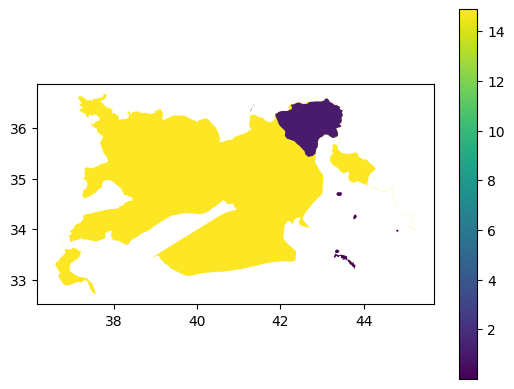

In [130]:
liveuamap_iraq_clean[(liveuamap_iraq_clean['date_dt']=='2016-10-01')&(liveuamap_iraq_clean['Name']=='isis_syria')].plot(column='Shape_Area',legend=True)

**Note**: there are duplicates in the Liveuamap data, down to the geometries. For example, see indices [406, 413, 399] in the original dataframe. We dissolve the Liveuamap geometries by date and agent in control.

In [147]:
# to see records that will be dropped as duplicates
liveuamap_iraq_diss[liveuamap_iraq_diss.duplicated(keep=False)]

,date_dt,control_agent,geometry


### First, simple spatial join
This will give a complete list of all territorial control recorded in liveuamap in all adm3 areas, leaving out any calculations of percentage of each adm3 area controlled by each controlling agent. 

In [148]:
iraq_shp_adm3_simp = iraq_shp_adm3.loc[:,['ADM3_EN','geometry']]
print(len(iraq_shp_adm3_simp['ADM3_EN'].unique()))
liveuamap_iraq_adm3 = iraq_shp_adm3_simp.sjoin(liveuamap_iraq_diss)
print(liveuamap_iraq_diss.shape)
print(liveuamap_iraq_adm3.shape)
print(len(liveuamap_iraq_adm3['date_dt'].unique()))
print(len(liveuamap_iraq_adm3['ADM3_EN'].unique()))


294
(379, 3)
(32727, 5)
111
294


In [ ]:
# if want to test visualizing some duplicates without dropping duplicates from liveuamap data first, 
# perform the join and then run this code
#test_dups = liveuamap_iraq_adm3[liveuamap_iraq_adm3.duplicated(subset=['ADM3_EN','date_dt','Name'],keep=False)]
#test_indices = test_dups[(test_dups['ADM3_EN']=='Abu Ghraib')&(test_dups['Name']=='isis_syria')]['index_right']
#print(list(test_indices))
#test_map = liveuamap_iraq_clean[liveuamap_iraq_clean.index.isin(list(test_indices))]
#test_map.loc[:,'col_col'] = pd.Series([1,2,3],index=[399,406,413])
#test_map.sort_values(['col_col'],ascending=False).plot(column='col_col',legend=True)
#test_map.plot(column='col_col',legend=True)

In [149]:
liveuamap_iraq_adm3_full = liveuamap_iraq_adm3.drop(columns=['geometry','index_right'])

liveuamap_iraq_adm3_full_joins_loc = source_dir + '/data/liveuamap/adm3_liveuamap_control_areas_monthly.csv'
liveuamap_iraq_adm3_full.to_csv(liveuamap_iraq_adm3_full_joins_loc,index=False)

In [151]:
# confirm no more duplicated geometries in the liveuamap data
liveuamap_iraq_adm3[liveuamap_iraq_adm3.duplicated(subset=['ADM3_EN','date_dt','control_agent'],keep=False)].sort_values(['ADM3_EN','date_dt'])

,ADM3_EN,geometry,index_right,date_dt,control_agent


### Next, calculate area of overlap for each controlling agent in each adm3 area

In [152]:
print(liveuamap_iraq_diss.shape)
liveuamap_iraq_adm3_overlay = iraq_shp_adm3_simp.to_crs("EPSG:3394").overlay(liveuamap_iraq_diss.to_crs("EPSG:3394"),how='union')
print(iraq_shp_adm3_simp.shape)
print(liveuamap_iraq_adm3_overlay.shape)

(379, 3)
(294, 2)
(33084, 4)


/home/npodpx/.virtualenvs/iraq_postconflict/lib/python3.9/site-packages/geopandas/geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 6090 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


In [ ]:
# some of the liveuamap areas aren't completely in Iraq; remove these
liveuamap_iraq_adm3_overlay = liveuamap_iraq_adm3_overlay[~liveuamap_iraq_adm3_overlay['ADM3_EN'].isna()]
# calculate area of overlap between each liveuamap control area and adm3 area
liveuamap_iraq_adm3_overlay.loc[:,'control_area'] = liveuamap_iraq_adm3_overlay.area

# calculate entire area of adm3 area to get proportions
iraq_shp_adm3_area = iraq_shp_adm3_simp.to_crs("EPSG:3394")
iraq_shp_adm3_area.loc[:,'adm3_area'] = iraq_shp_adm3_area.area
print(liveuamap_iraq_adm3_overlay.shape)

# use inner join (default) to remove some of the control areas which surround Iraq but are just outside of the 
# boundaries of the adm3 areas
iraq_adm3_control_areas = liveuamap_iraq_adm3_overlay.merge(iraq_shp_adm3_area.drop(columns=['geometry']),on='ADM3_EN')
iraq_adm3_control_areas = iraq_adm3_control_areas[~iraq_adm3_control_areas['control_agent'].isna()]
print(iraq_adm3_control_areas.shape)

In [157]:
# the adm3 areas which don't join with any Liveuamap areas will assume were never under any control recorded by Liveuamap,
# so were not under ISIS controll
print(len(iraq_adm3_control_areas[iraq_adm3_control_areas['control_agent'].isna()]['ADM3_EN']))
print(len(iraq_adm3_control_areas[iraq_adm3_control_areas['control_agent'].isna()]['ADM3_EN'].unique()))

0
0


In [158]:
iraq_adm3_control_areas.loc[:,'prop_control'] = iraq_adm3_control_areas['control_area'] / iraq_adm3_control_areas['adm3_area']

/home/npodpx/.virtualenvs/iraq_postconflict/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [159]:
# confirm the dissolving solved the duplicates issue
test_isis = iraq_adm3_control_areas[iraq_adm3_control_areas['control_agent']=='isis']
test_isis[test_isis.duplicated(subset=['date_dt','ADM3_EN'],keep=False)]

,ADM3_EN,date_dt,control_agent,geometry,control_area,adm3_area,prop_control


In [160]:
iraq_adm3_isis_areas = iraq_adm3_control_areas[iraq_adm3_control_areas['control_agent']=='isis']
iraq_adm3_isis_areas = iraq_adm3_isis_areas.drop(columns=['geometry'])
iraq_adm3_isis_areas = iraq_adm3_isis_areas.rename(columns={'prop_control':'perc_isis_control',
                                                            'adm3_area':'full_adm3_area'})

In [161]:
liveuamap_iraq_adm3_full_joins_loc = source_dir + '/data/liveuamap/adm3_liveuamap_isis_perc_control_monthly.csv'

iraq_adm3_isis_areas.to_csv(liveuamap_iraq_adm3_full_joins_loc,index=False)

In [79]:
#liveuamap_iraq_adm3_isis = liveuamap_iraq_adm3_full[liveuamap_iraq_adm3_full['control_agent']=='isis']
liveuamap_iraq_adm3_isis = liveuamap_iraq_adm3_full.drop(columns=['Name','Shape_Leng','Shape_Area'])
print(liveuamap_iraq_adm3_isis.shape)
# remove cases where multiple names for ISIS (eg, ISIS-Iraq and isis) were in the same admin area
liveuamap_iraq_adm3_isis = liveuamap_iraq_adm3_isis.drop_duplicates()
print(liveuamap_iraq_adm3_isis.shape)

liveuamap_iraq_adm3_isis_test = liveuamap_iraq_adm3_isis.groupby(['ADM3_EN','date_dt']).count()

(33983, 3)
(32727, 3)


In [80]:
liveuamap_iraq_adm3_isis_test[liveuamap_iraq_adm3_isis_test['control_agent']>1]
#liveuamap_iraq_adm3_isis_test

control_agent
ADM3_EN   date_dt                  
Al-Abbasi 2016-07-01              2
          2016-08-01              2
          2016-09-01              2
          2016-10-01              2
          2016-11-01              2
...                             ...
Zummar    2023-08-01              2
          2023-09-01              2
          2023-10-01              2
          2023-11-01              2
          2023-12-01              2

[3999 rows x 1 columns]